In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy cantera --quiet

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import cantera as ct
from scipy.optimize import minimize

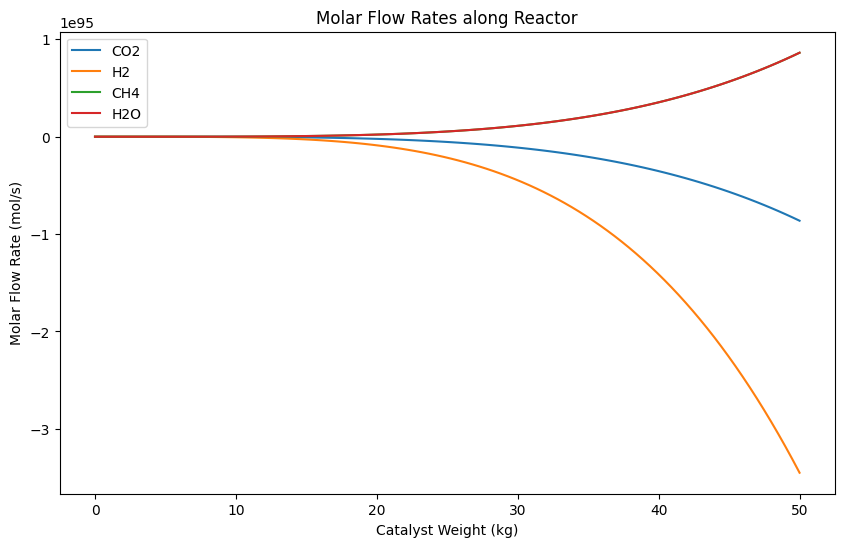

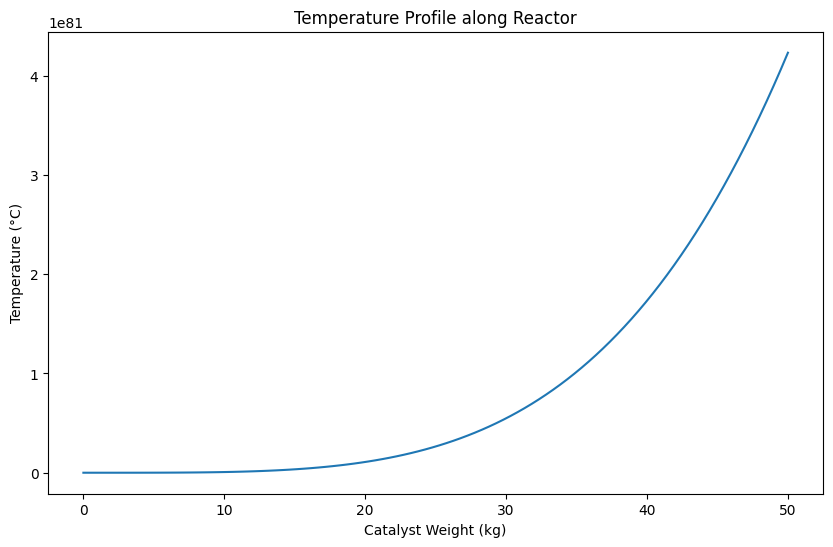

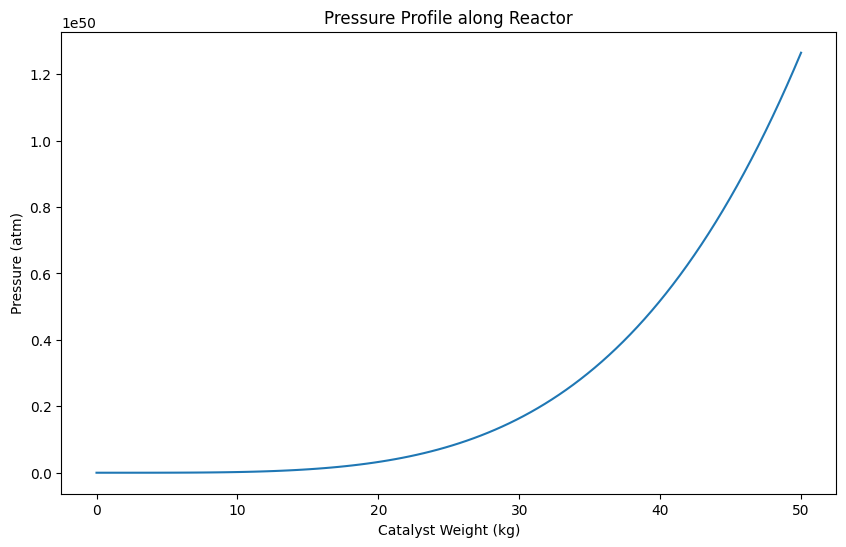

/var/folders/fh/ct4dhs1d7pq42n_96f1hwzkw0000gn/T/ipykernel_33792/3585245777.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dP_dW = float(-(G / rho_bulk) * ((150 * mu * (1 - epsilon)) / (D_p**2 * epsilon**3) + (1.75 * G) / (D_p * epsilon**3)))
/var/folders/fh/ct4dhs1d7pq42n_96f1hwzkw0000gn/T/ipykernel_33792/3585245777.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  return (k * P_CO2 * P_H2**4) / ((1 + K_CO2 * P_CO2 + K_H2 * P_H2)**2)
/var/folders/fh/ct4dhs1d7pq42n_96f1hwzkw0000gn/T/ipykernel_33792/3585245777.py:40: RuntimeWarning: invalid value encountered in scalar add
  F_total = F_CO2 + F_H2 + F_CH4 + F_H2O


Optimal vertical scaling factor: 1.0000089474239375
Vertical scaling is more effective.


In [ ]:
# Thermodynamic Calculations Module (thermodynamics.py)
def calculate_cp(T, species):
    """Calculate the heat capacity of a species at temperature T."""
    # Placeholder function - actual implementation should use temperature-dependent correlations
    return 29.1  # J/(mol·K), example value for methane

# Kinetic Models Module (kinetics.py)
def reaction_rate(P_CO2, P_H2, k, K_CO2, K_H2):
    """Calculate reaction rate using Langmuir-Hinshelwood kinetics."""
    return (k * P_CO2 * P_H2**4) / ((1 + K_CO2 * P_CO2 + K_H2 * P_H2)**2)

# Reactor Model Module (reactor_model.py)
def sabatier_reactor_model(W, y, params):
    """
    Define the ODE system for the Sabatier reactor.
    Arguments:
        W : Catalyst weight (kg)
        y : Array of dependent variables (molar flow rates, temperature, pressure)
        params : Dictionary of parameters (reaction constants, heat capacity, etc.)
    Returns:
        dydW : Array of derivatives
    """
    F_CO2, F_H2, F_CH4, F_H2O, T, P = y

    # Unpack parameters
    k = params['k']
    K_CO2 = params['K_CO2']
    K_H2 = params['K_H2']
    Cp = params['Cp']
    delta_H = params['delta_H']
    U = params['U']
    T_env = params['T_env']
    F_total = F_CO2 + F_H2 + F_CH4 + F_H2O

    # Reaction rate
    P_CO2 = F_CO2 / F_total * P if F_total != 0 else 0.0
    P_H2 = F_H2 / F_total * P if F_total != 0 else 0.0
    r = reaction_rate(P_CO2, P_H2, k, K_CO2, K_H2)

    # Mass balances
    dF_CO2_dW = float(-r)
    dF_H2_dW = float(-4 * r)
    dF_CH4_dW = float(r)
    dF_H2O_dW = float(r)

    # Energy balance
    dT_dW = float((-delta_H * r + U * (T_env - T)) / (F_total * Cp)) if F_total != 0 else 0.0

    # Pressure drop using Ergun equation
    G = params['G']  # Mass flux (kg/(m²·s))
    mu = params['mu']  # Gas viscosity (Pa·s)
    epsilon = params['epsilon']  # Bed void fraction
    D_p = params['D_p']  # Catalyst particle diameter (m)
    rho_bulk = params['rho_bulk']  # Bulk density of the catalyst bed (kg/m³)
    dP_dW = float(-(G / rho_bulk) * ((150 * mu * (1 - epsilon)) / (D_p**2 * epsilon**3) + (1.75 * G) / (D_p * epsilon**3)))

    return np.array([dF_CO2_dW, dF_H2_dW, dF_CH4_dW, dF_H2O_dW, dT_dW, dP_dW], dtype=np.float64)

# Main Script (main.py)
def main():
    # Initial conditions
    F_CO2_0 = 1.0  # mol/s
    F_H2_0 = 4.0  # mol/s
    F_CH4_0 = 0.0  # mol/s
    F_H2O_0 = 0.0  # mol/s
    T_0 = 300 + 273.15  # K (initial temperature)
    P_0 = 10  # atm (initial pressure)
    y0 = np.array([F_CO2_0, F_H2_0, F_CH4_0, F_H2O_0, T_0, P_0], dtype=np.float64)

    # Parameters
    params = {
        'k': 0.1,  # Rate constant
        'K_CO2': 0.05,  # Adsorption equilibrium constant for CO2
        'K_H2': 0.02,  # Adsorption equilibrium constant for H2
        'Cp': 29.1,  # Heat capacity of the gas mixture (J/(mol·K))
        'delta_H': -165000,  # Reaction enthalpy (J/mol)
        'U': 50,  # Overall heat transfer coefficient (W/(kg·K))
        'T_env': 300 + 273.15,  # Environmental temperature (K)
        'G': 100,  # Mass flux (kg/(m²·s))
        'mu': 1e-5,  # Gas viscosity (Pa·s)
        'epsilon': 0.4,  # Bed void fraction
        'D_p': 0.005,  # Catalyst particle diameter (m)
        'rho_bulk': 800,  # Bulk density of the catalyst bed (kg/m³)
    }

    # Catalyst weight span
    W_span = (0, 50)  # kg of catalyst

    # Solve the ODEs
    sol = solve_ivp(sabatier_reactor_model, W_span, y0, args=(params,), dense_output=True)

    # Plot results
    W = np.linspace(W_span[0], W_span[1], 100)
    results = sol.sol(W)
    plot_profiles(W, results.T)

    # Optimization to scale system horizontally vs vertically
    optimize_scaling(params, y0)

# Optimization Module (optimization.py)
def optimize_scaling(params, y0):
    """
    Optimize reactor scaling strategy: horizontally (multiple reactors) or vertically (larger reactor).
    """
    def objective(vertical_factor):
        """Objective function to minimize: negative CH4 production."""
        params_scaled = params.copy()
        params_scaled['G'] *= vertical_factor  # Scale mass flux
        W_span = (0, 50 * vertical_factor)  # Scale catalyst weight
        sol = solve_ivp(sabatier_reactor_model, W_span, y0, args=(params_scaled,), dense_output=True)
        F_CH4_out = sol.y[2, -1]  # CH4 molar flow rate at the reactor outlet
        return -F_CH4_out

    # Perform optimization
    result = minimize(objective, x0=np.array([1.0]), bounds=[(0.5, 10.0)], method='L-BFGS-B')
    optimal_vertical_factor = result.x[0]
    print(f"Optimal vertical scaling factor: {optimal_vertical_factor}")

    # Compare horizontal and vertical scaling
    horizontal_performance = simulate_horizontal_scaling(params, y0)
    vertical_performance = simulate_vertical_scaling(params, y0, optimal_vertical_factor)

    if vertical_performance > horizontal_performance:
        print("Vertical scaling is more effective.")
    else:
        print("Horizontal scaling is more effective.")

def simulate_horizontal_scaling(params, y0):
    """Simulate performance of multiple smaller reactors (horizontal scaling)."""
    num_reactors = 5
    total_CH4_production = 0
    for _ in range(num_reactors):
        W_span = (0, 10)  # Smaller reactor
        sol = solve_ivp(sabatier_reactor_model, W_span, y0, args=(params,), dense_output=True)
        total_CH4_production += sol.y[2, -1]
    return total_CH4_production

def simulate_vertical_scaling(params, y0, vertical_factor):
    """Simulate performance of a larger reactor (vertical scaling)."""
    params_scaled = params.copy()
    params_scaled['G'] *= vertical_factor
    W_span = (0, 50 * vertical_factor)
    sol = solve_ivp(sabatier_reactor_model, W_span, y0, args=(params_scaled,), dense_output=True)
    return sol.y[2, -1]

# Visualization Module (visualization.py)
def plot_profiles(W_span, results):
    F_CO2 = results[:, 0]
    F_H2 = results[:, 1]
    F_CH4 = results[:, 2]
    F_H2O = results[:, 3]
    T = results[:, 4] - 273.15  # Convert K to °C
    P = results[:, 5]  # Pressure in atm

    # Plot concentrations
    plt.figure(figsize=(10, 6))
    plt.plot(W_span, F_CO2, label='CO2')
    plt.plot(W_span, F_H2, label='H2')
    plt.plot(W_span, F_CH4, label='CH4')
    plt.plot(W_span, F_H2O, label='H2O')
    plt.xlabel('Catalyst Weight (kg)')
    plt.ylabel('Molar Flow Rate (mol/s)')
    plt.title('Molar Flow Rates along Reactor')
    plt.legend()
    plt.show()

    # Plot temperature profile
    plt.figure(figsize=(10, 6))
    plt.plot(W_span, T)
    plt.xlabel('Catalyst Weight (kg)')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature Profile along Reactor')
    plt.show()

    # Plot pressure profile
    plt.figure(figsize=(10, 6))
    plt.plot(W_span, P)
    plt.xlabel('Catalyst Weight (kg)')
    plt.ylabel('Pressure (atm)')
    plt.title('Pressure Profile along Reactor')
    plt.show()

main()

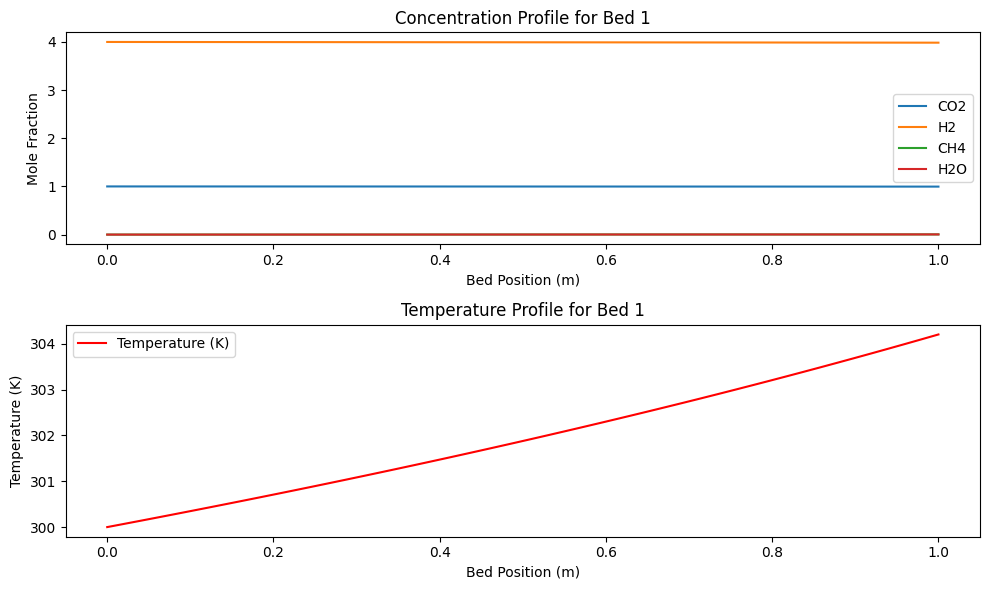

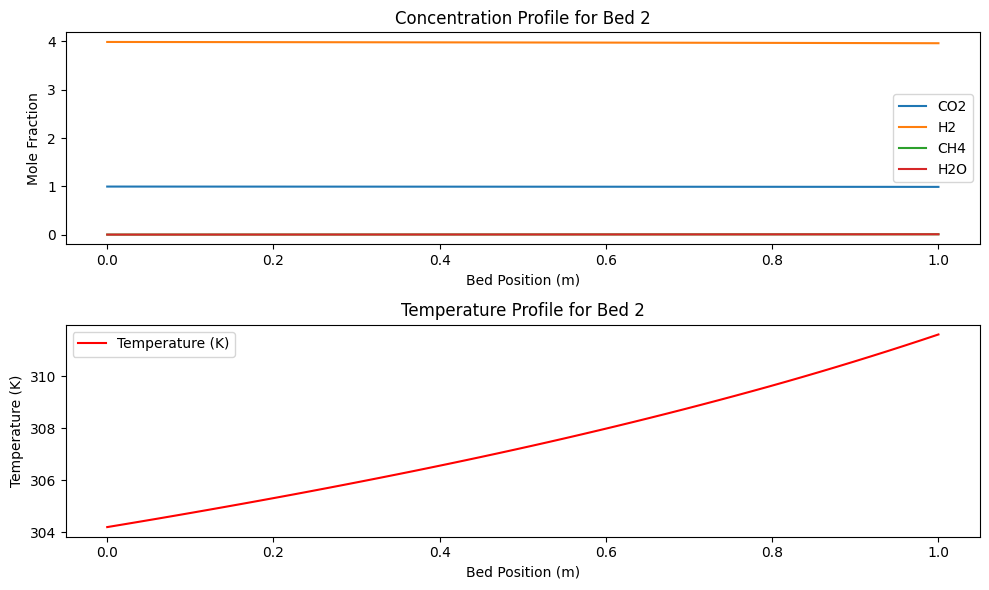

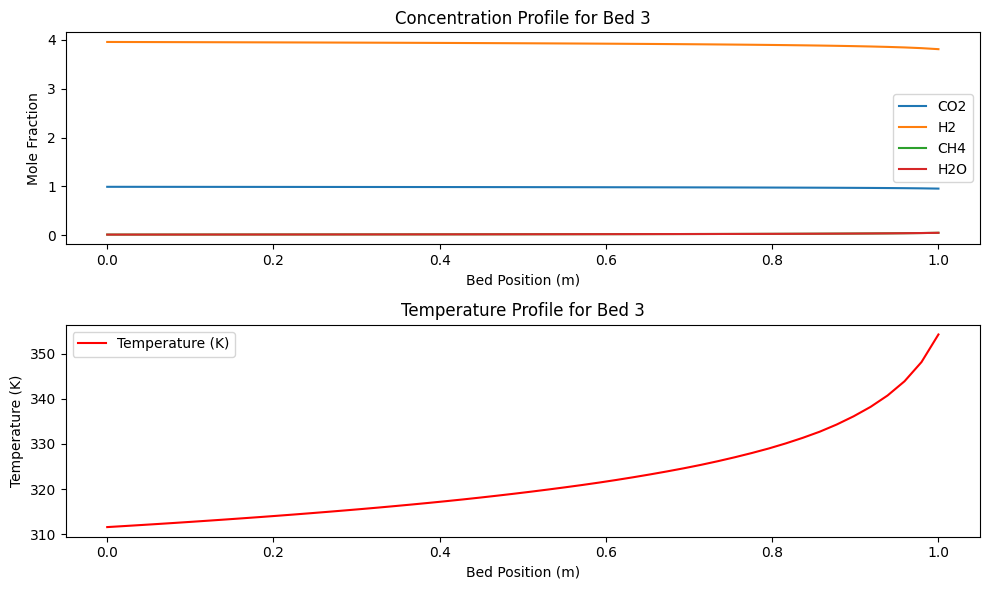

In [1]:

import numpy as np
from scipy.integrate import solve_ivp

# Constants and Reaction Parameters
R = 8.314  # Universal gas constant in J/(mol*K)
activation_energy = 80000  # Activation energy in J/mol
pre_exponential_factor = 1e9  # Pre-exponential factor in 1/s
heat_of_reaction = -165000  # Enthalpy change for methanation in J/mol
specific_heat_capacity = 29.1  # Approximate Cp for gas mixture in J/(mol*K)

# Initial Conditions
initial_CO2 = 1.0  # mol fraction CO2
initial_H2 = 4.0  # mol fraction H2
initial_CH4 = 0.0  # mol fraction CH4
initial_H2O = 0.0  # mol fraction H2O
initial_T = 300  # Initial temperature in K

# Bed and Simulation Parameters
num_beds = 3  # Number of adiabatic beds
bed_length = 1.0  # Length of each bed in meters
num_nodes = 50  # Discretize each bed into nodes
z = np.linspace(0, bed_length, num_nodes)

# Kinetics Function
def reaction_rate(CO2, H2, T):
    """Calculate reaction rate based on Arrhenius equation."""
    rate_constant = pre_exponential_factor * np.exp(-activation_energy / (R * T))
    return rate_constant * CO2 * H2**4

# Differential Equations for Mass and Energy Balances
def bed_model(z, y):
    """Model for a single bed segment, returns derivatives of components."""
    CO2, H2, CH4, H2O, T = y
    
    # Reaction rate
    r = reaction_rate(CO2, H2, T)
    
    # Mass balances
    dCO2_dz = -r
    dH2_dz = -4 * r
    dCH4_dz = r
    dH2O_dz = r
    
    # Energy balance (adiabatic)
    dT_dz = (-heat_of_reaction * r) / (specific_heat_capacity * (CO2 + H2 + CH4 + H2O))
    
    return [dCO2_dz, dH2_dz, dCH4_dz, dH2O_dz, dT_dz]

# Simulation across multiple beds
def simulate_methanation(num_beds, initial_conditions):
    results = []
    inlet_conditions = initial_conditions
    
    for i in range(num_beds):
        sol = solve_ivp(
            bed_model, [0, bed_length], inlet_conditions, t_eval=z, method="BDF"
        )
        
        # Store results for this bed
        results.append(sol.y)
        
        # Update inlet for next bed
        inlet_conditions = [sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1], sol.y[4][-1]]
    
    return results, z

# Run the Simulation
initial_conditions = [initial_CO2, initial_H2, initial_CH4, initial_H2O, initial_T]
results, z = simulate_methanation(num_beds, initial_conditions)

# Plot Results
import matplotlib.pyplot as plt

for i in range(num_beds):
    CO2_profile, H2_profile, CH4_profile, H2O_profile, T_profile = results[i]
    
    plt.figure(figsize=(10, 6))
    
    # Concentration Profiles
    plt.subplot(2, 1, 1)
    plt.plot(z, CO2_profile, label="CO2")
    plt.plot(z, H2_profile, label="H2")
    plt.plot(z, CH4_profile, label="CH4")
    plt.plot(z, H2O_profile, label="H2O")
    plt.xlabel("Bed Position (m)")
    plt.ylabel("Mole Fraction")
    plt.title(f"Concentration Profile for Bed {i+1}")
    plt.legend()
    
    # Temperature Profile
    plt.subplot(2, 1, 2)
    plt.plot(z, T_profile, label="Temperature (K)", color="red")
    plt.xlabel("Bed Position (m)")
    plt.ylabel("Temperature (K)")
    plt.title(f"Temperature Profile for Bed {i+1}")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
